작업중

In [49]:
import jax
import jax.numpy as jnp
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import yfinance as yf
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

In [66]:
# 논문에 첨부된 간략한 구현
# import jax
# import jax.numpy as jnp
# import numpy as np
# parallel_scan = jax.lax.associative_scan

# def lruforward(lru_parameters, input_sequence):
#   """Forward pass of the LRU layer. Output y and input_sequence are of shape (L, H)."""
#   # All LRU parameters
#   nu_log, theta_log, B_re, B_im, C_re, C_im, D, gamma_log = lru_parameters
#   # Materializing the diagonal of Lambda and projections
#   Lambda = jnp.exp(-jnp.exp(nu_log) + 1j * jnp.exp(theta_log))
#   B_norm = (B_re + 1j * B_im) * jnp.expand_dims(jnp.exp(gamma_log), axis=-1)
#   C = C_re + 1j * C_im
#   # Running the LRU + output projection
#   # For details on parallel scan, check discussion in Smith et al (2022).
#   Lambda_elements = jnp.repeat(Lambda[None, ...], input_sequence.shape[0], axis=0)  # input_sequence.shape[0]
#   Bu_elements = jax.vmap(lambda u: B_norm.T @ u)(input_sequence)
#   elements = (Lambda_elements, Bu_elements)
#   _, inner_states = parallel_scan(binary_operator_diag, elements)  # all x_k
#   y = jax.vmap(lambda x, u: (C @ x).real + D * u)(inner_states, input_sequence)
#   return y

# def init_lru_parameters(N, H, r_min=0, r_max=1, max_phase=6.28):
#   """Initialize parameters of the LRU layer."""
#   # N: state dimension, H: model dimension
#   # Initialization of Lambda is complex valued distributed uniformly on ring
#   # between r_min and r_max, with phase in [0, max_phase].
#   u1 = np.random.uniform(size=(N,))
#   u2 = np.random.uniform(size=(N,))
#   nu_log = np.log(-0.5 * np.log(u1 * (r_max**2 - r_min**2) + r_min**2))
#   theta_log = np.log(max_phase * u2)
#   # Glorot initialized Input/Output projection matrices
#   B_re = np.random.normal(size=(N, H)) / np.sqrt(2 * H)
#   # Normalization factor
#   B_im = np.random.normal(size=(N, H)) / np.sqrt(2 * H)
#   C_re = np.random.normal(size=(H, N)) / np.sqrt(N)
#   C_im = np.random.normal(size=(H, N)) / np.sqrt(N)
#   D = np.random.normal(size=(H,))
#   diag_lambda = np.exp(-np.exp(nu_log) + 1j * np.exp(theta_log))
#   gamma_log = np.log(np.sqrt(1 - np.abs(diag_lambda)**2))
#   return nu_log, theta_log, B_re, B_im, C_re, C_im, D, gamma_log

# def binary_operator_diag(element_i, element_j):
#   # Binary operator for parallel scan of linear recurrence.
#   a_i, bu_i = element_i
#   a_j, bu_j = element_j
#   return a_j * a_i, a_j * bu_i + bu_j

In [89]:
def complex_mul(a_re, a_im, b_re, b_im):
  # 복소수 곱셈
  return a_re * b_re - a_im * b_im, a_re * b_im + a_im * b_re

def lruforward(lru_parameters, input_sequence):
  nu_log, theta_log, B_re, B_im, C_re, C_im, D, gamma_log = lru_parameters
  L, H = input_sequence.shape
  N = nu_log.shape[0]

  lam_mag = torch.exp(-torch.exp(nu_log))
  lam_phase = torch.exp(theta_log)
  Lambda_re = lam_mag * torch.cos(lam_phase)
  Lambda_im = lam_mag * torch.sin(lam_phase)

  exp_gamma = torch.exp(gamma_log)
  B_norm_re = B_re * exp_gamma.unsqueeze(-1)
  B_norm_im = B_im * exp_gamma.unsqueeze(-1)

  Bu_re = (input_sequence @ B_norm_re)
  Bu_im = (input_sequence @ B_norm_im)

  # 상태 업데이트
  x_re = torch.zeros(N, device=input_sequence.device, dtype=torch.float32)
  x_im = torch.zeros(N, device=input_sequence.device, dtype=torch.float32)
  inner_states_re, inner_states_im = [], []
  for k in range(L):
    prod_re, prod_im = complex_mul(Lambda_re, Lambda_im, x_re, x_im)
    x_re = prod_re + Bu_re[k]
    x_im = prod_im + Bu_im[k]
    inner_states_re.append(x_re)
    inner_states_im.append(x_im)
  inner_states_re = torch.stack(inner_states_re, dim=0)  # (L, N)
  inner_states_im = torch.stack(inner_states_im, dim=0)  # (L, N)

  # 최종 출력
  y_list = []
  for k in range(L):
    # 복소수 행렬-벡터 곱
    y_k = torch.matmul(C_re, inner_states_re[k]) - torch.matmul(C_im, inner_states_im[k])
    y_list.append(y_k + D * input_sequence[k])
    y = torch.stack(y_list, dim=0)  # (L, H)
  return y

def init_lru_parameters(N, H, r_min=0, r_max=1, max_phase=6.28):
  """
  LRU layer 파라미터 초기화.
  N: 상태(숨겨진) 차원, H: 모델 차원.
  Lambda는 r_min과 r_max 사이의 링에 균일하게 분포하고, 위상은 [0, max_phase] 범위입니다.
  """
  # 균일 분포: [0,1) 범위에서 샘플링
  u1 = torch.rand(N)
  u2 = torch.rand(N)
  # nu_log = log(-0.5 * log(u1*(r_max^2 - r_min^2) + r_min^2))
  nu_log = torch.log(-0.5 * torch.log(u1 * (r_max**2 - r_min**2) + r_min**2))
  # theta_log = log(max_phase * u2)
  theta_log = torch.log(max_phase * u2)

  # Glorot 초기화, torch.randn으로 정규분포 샘플링
  B_re = torch.randn(N, H) / torch.sqrt(torch.tensor(2 * H, dtype=torch.float32))
  B_im = torch.randn(N, H) / torch.sqrt(torch.tensor(2 * H, dtype=torch.float32))
  C_re = torch.randn(H, N) / torch.sqrt(torch.tensor(N, dtype=torch.float32))
  C_im = torch.randn(H, N) / torch.sqrt(torch.tensor(N, dtype=torch.float32))
  D = torch.randn(H)

  # diag_lambda = exp(-exp(nu_log) + i * exp(theta_log))
  diag_lambda = torch.exp(-torch.exp(nu_log) + 1j * torch.exp(theta_log))
  # gamma_log = log(sqrt(1 - |diag_lambda|^2))
  gamma_log = torch.log(torch.sqrt(1 - torch.abs(diag_lambda)**2))

  return nu_log, theta_log, B_re, B_im, C_re, C_im, D, gamma_log

In [91]:
class LRURNN(nn.Module):
  def __init__(self, data, seq_len: int, input_size: int, hidden_size: int, output_size: int, batch_size: int) -> None:
    super().__init__()
    # self.seq_len = seq_len
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.batch_size = batch_size
    self.i2h = nn.Linear(input_size, hidden_size, bias=False)
    self.h2h = nn.Linear(hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.lru_params = init_lru_parameters(self.hidden_size, self.hidden_size)

  def forward(self, x, hidden_state) -> tuple[torch.Tensor, torch.Tensor]:
    x = self.i2h(x)
    hidden_state = self.h2h(hidden_state)
    # hidden_state_np = hidden_state.detach().cpu().numpy()
    hidden_state = lruforward(lru_parameters=self.lru_params, input_sequence=hidden_state)
    out = self.h2o(hidden_state)
    return out, hidden_state

  def init_zero_hidden(self, batch_size=1) -> torch.Tensor:
    return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

In [99]:
def train(model: LRURNN, data: DataLoader, epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module) -> None:
  train_losses = {}
  model.to(device)

  model.train()
  print("=> Starting training")
  for epoch in range(epochs):
    epoch_losses = list()
    for X, Y in data:
      if X.shape[0] != model.batch_size:
        continue
      hidden = model.init_zero_hidden(batch_size=model.batch_size)
      X, Y, hidden = X.to(device), Y.to(device), hidden.to(device)
      model.zero_grad()
      loss = 0
      for c in range((Y.shape[1])):
        out, hidden = model(X[:, c].unsqueeze(1), hidden) # model(X[:, c].reshape(X.shape[0],1), hidden)
        l = loss_fn(out, Y[:, c].unsqueeze(1).float())
        loss += l
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 3)
      optimizer.step()

      epoch_losses.append(loss.detach().item() / X.shape[1])
    train_losses[epoch] = torch.tensor(epoch_losses).mean()
    print(f'=> epoch: {epoch + 1}, loss: {train_losses[epoch]}')

In [ ]:
ticker = "AAPL"
start_date = "2022-01-01"
end_date = "2023-01-01"
stock = yf.Ticker(ticker)
df = stock.history(start=start_date, end=end_date)
df

In [102]:
class TimeSeriesDataset(Dataset):
  def __init__(self, data, seq_length):
    self.data = data
    self.seq_length = seq_length

  def __len__(self):
    return len(self.data) - self.seq_length

  def __getitem__(self, idx):
    X = self.data[idx:idx + self.seq_length]  # Input sequence
    Y = self.data[idx + self.seq_length]  # Target sequence(1만큼 시프트)
    return X, Y

In [ ]:
data = df.reset_index()
data = df[['Open','High','Low','Close','Volume']]
data = torch.Tensor(data.values)
seq_length = 10
input_size = data.shape[1]
output_size = data.shape[1]
batch_size = 16
hidden_size = 32

dataset = TimeSeriesDataset(data, seq_length)
dataloader = DataLoader(dataset, batch_size)

lrurnnModel = LRURNN(data=data, seq_len=seq_length, input_size=input_size, output_size=output_size, hidden_size=hidden_size, batch_size=batch_size)

epochs = 1000
loss = nn.MSELoss()
optimizer = optim.RMSprop(lrurnnModel.parameters(), lr = 0.005)

train(lrurnnModel, dataloader, epochs, optimizer, loss)

In [ ]:
33_377_541_423_104.0
33_377_541_423_104.0
37_784_945_426_432.0

In [105]:
import matplotlib.pyplot as plt

def evaluate_model(model, dataset):
  model.eval()
  predictions = []
  ground_truth = []
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False) # 배치 1로 해서 시계열 유지
  with torch.no_grad():
    for x, y in dataloader:
      hidden = model.init_zero_hidden(batch_size=x.size(0)).to(device)
      x = x.to(device)
      out, _ = model(x, hidden)
      predictions.append(out.cpu().numpy().squeeze())
      ground_truth.append(y.cpu().numpy().squeeze())
  return np.array(predictions), np.array(ground_truth)

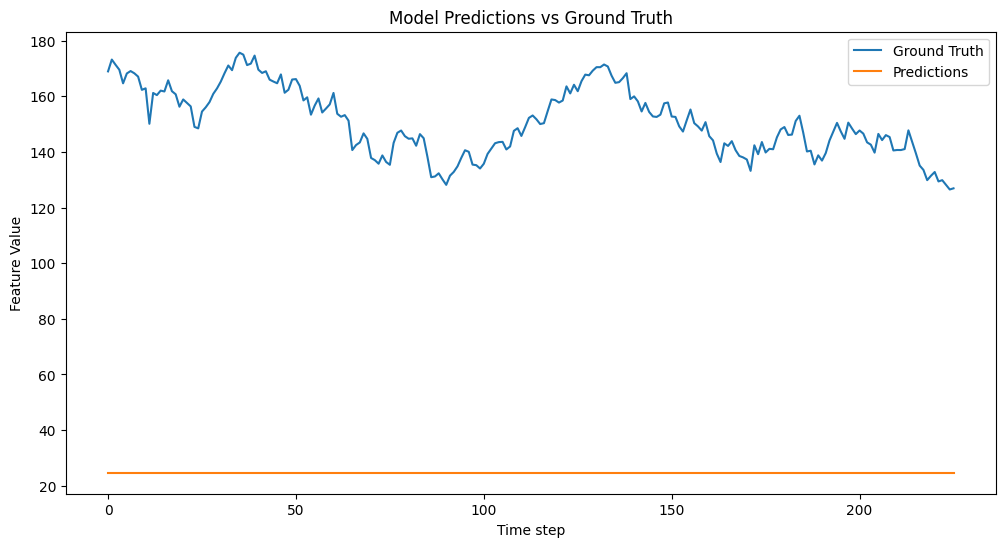

In [106]:
evaluate_model(lrurnnModel, dataset)
preds, truths = evaluate_model(lrurnnModel, dataset)
feature_idx = 0

plt.figure(figsize=(12, 6))
plt.plot(truths[:, feature_idx], label="Ground Truth")
plt.plot(preds[:, feature_idx], label="Predictions")
plt.title("Model Predictions vs Ground Truth")
plt.xlabel("Time step")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

In [109]:
preds

array([[24.661018, 24.608793, 25.024075, 24.75819 , 24.974737],
       [24.661018, 24.608793, 25.024075, 24.75819 , 24.974737],
       [24.661018, 24.608793, 25.024075, 24.75819 , 24.974737],
       ...,
       [24.661018, 24.608793, 25.024075, 24.75819 , 24.974737],
       [24.661018, 24.608793, 25.024075, 24.75819 , 24.974737],
       [24.661018, 24.608793, 25.024075, 24.75819 , 24.974737]],
      dtype=float32)